## quant-econ Solutions: Discrete Dynamic Programming

Solutions for http://quant-econ.net/py/discrete_dp.html

Prepared by **Daisuke Oyama**, Faculty of Economics, University of Tokyo

The exercise is to replicate numerically the analytical solution for the benchmark model in  [this lecture](http://quant-econ.net/py/dp_intro.html) of quant-econ, using the `DiscreteDP` class.  

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from quantecon import compute_fixed_point
from quantecon.markov import DiscreteDP

## Setup

To recall, we consider the following problem:
$$
\begin{aligned}
&\max_{\{c_t\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^t u(c_t) \\
&\ \text{ s.t. }\ k_{t+1} = f(k_t) - c_t,
 \quad \text{$k_0$: given},
\end{aligned}
$$
where
$k_t$ and $c_t$ are the capital stock and consumption at time $t$, respectively,
$u$ is the utility function,
$f$ is the production function, and
$\beta \in (0, 1)$ is the discount factor.

As in the lecture,
we let $f(k) = k^{\alpha}$ with $\alpha = 0.65$, $u(c) = \log c$, and $\beta = 0.95$.

In [3]:
alpha = 0.65
f = lambda k: k**alpha
u = np.log
beta = 0.95

Here we want to solve a finite state version of the continuous state model above.
We discretize the state space into a grid of size `grid_size=1500`,
from $10^{-6}$ to `grid_max=2`.

The grid size in [the lecture](http://quant-econ.net/py/optgrowth.html) is 150,
where the value functions are approximated by linear interpolation,
while we choose a finer grid since we fill the gaps with discrete points.

In [4]:
grid_max = 2
grid_size = 1500
grid = np.linspace(1e-6, grid_max, grid_size)

In [5]:
print(grid)

[  1.00000000e-06   1.33522215e-03   2.66944430e-03 ...,   1.99733156e+00
   1.99866578e+00   2.00000000e+00]


We choose the action to be the amount of capital to save for the next period
(the state is the capical stock at the beginning of the period).
Thus the state indices and the action indices are both `0`, ..., `grid_size-1`.
Action (indexed by) `a` is feasible at state (indexed by) `s` if and only if
`grid[a] < f([grid[s])`
(zero consumption is not allowed because of the log utility).

Thus the Bellman equation is:
$$
v(k) = \max_{0 < k' < f(k)} u(f(k) - k') + \beta v(k'),
$$
where $k'$ is the capital stock in the next period.

The transition probability array `Q` will be highly sparse
(in fact it is degenerate as the model is deterministic),
so we formulate the problem with state-action pairs, to represent `Q` in
[scipy sparse matrix format](http://docs.scipy.org/doc/scipy/reference/sparse.html).

We first construct indices for state-action pairs:

In [6]:
# Consumption matrix, with nonpositive consumption included
C = f(grid).reshape(grid_size, 1) - grid.reshape(1, grid_size)

# State-action indices
s_indices, a_indices = np.where(C > 0)

# Number of state-action pairs
L = len(s_indices)

In [7]:
print(L)
print(s_indices)
print(a_indices)

1069790
[   0    1    1 ..., 1499 1499 1499]
[   0    0    1 ..., 1174 1175 1176]


Reward vector `R` (of length `L`):

In [8]:
R = u(C[s_indices, a_indices])

(Degenerate) transition probability matrix `Q` (of shape `(L, grid_size)`),
where we choose the [scipy.sparse.lil_matrix](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html)
format,
while any format will do
(internally it will be converted to the csr format):

In [9]:
Q = sparse.lil_matrix((L, grid_size))
Q[np.arange(L), a_indices] = 1

(If you are familar with the data structure of
[scipy.sparse.csr_matrix](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html),
the following is the most efficient way to create the `Q` matrix in the current case.)

In [10]:
# data = np.ones(L)
# indptr = np.arange(L+1)
# Q = sparse.csr_matrix((data, a_indices, indptr), shape=(L, grid_size))

Discrete growth model:

In [11]:
ddp = DiscreteDP(R, Q, beta, s_indices, a_indices)

**Notes**

Here we intensively vectorized the operations on arrays to simplify the code.
As [noted](http://quant-econ.net/py/need_for_speed.html#pros-and-cons-of-vectorization),
however, vectorization is memory consumptive,
and it can be prohibitively so for grids with large size.

## Solving the model

Solve the dynamic optimization problem:

In [12]:
res = ddp.solve(method='policy_iteration')
v, sigma, num_iter = res.v, res.sigma, res.num_iter

In [13]:
num_iter

14

Note that `sigma` contains the *indices* of the optimal *capital stocks*
to save for the next period.
The following translates `sigma` to the corresponding consumption vector.

In [14]:
# Optimal consumption in the discrete version
c = f(grid) - grid[sigma]

In [15]:
# Exact solution of the continuous version
ab = alpha * beta
c1 = (np.log(1 - ab) + np.log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)
def v_star(k):
    return c1 + c2 * np.log(k)

def c_star(k):
    return (1 - ab) * k**alpha

Let us compare the solution of the discrete model with that of the original continuous model.

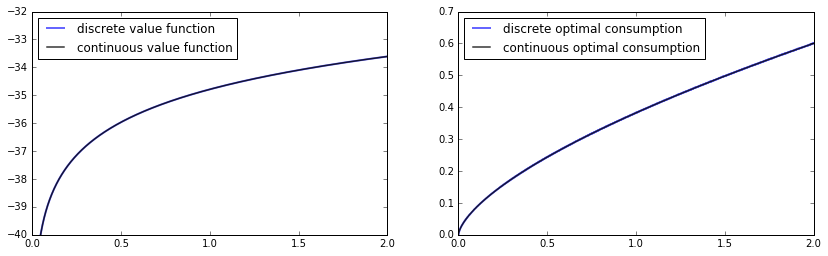

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].set_ylim(-40, -32)
ax[0].set_xlim(grid[0], grid[-1])
ax[1].set_xlim(grid[0], grid[-1])

lb0 = 'discrete value function'
ax[0].plot(grid, v, lw=2, alpha=0.6, label=lb0)

lb0 = 'continuous value function'
ax[0].plot(grid, v_star(grid), 'k-', lw=1.5, alpha=0.8, label=lb0)
ax[0].legend(loc='upper left')

lb1 = 'discrete optimal consumption'
ax[1].plot(grid, c, 'b-', lw=2, alpha=0.6, label=lb1)

lb1 = 'continuous optimal consumption'
ax[1].plot(grid, c_star(grid), 'k-', lw=1.5, alpha=0.8, label=lb1)
ax[1].legend(loc='upper left')
plt.show()

The outcomes appear very close to those of the continuous version.

Except for the "boundary" point, the value functions are very close:

In [17]:
np.abs(v - v_star(grid)).max()

121.49819147053378

In [18]:
np.abs(v - v_star(grid))[1:].max()

0.0038595076780651993

The optimal consumption functions are close as well:

In [19]:
np.abs(c - c_star(grid)).max()

0.0013020872868430011

In fact, the optimal consumption obtained in the discrete version is not really monotone,
but the decrements are quit small:

In [20]:
diff = np.diff(c)
(diff >= 0).all()

False

In [21]:
dec_ind = np.where(diff < 0)[0]

In [22]:
len(dec_ind)

521

In [23]:
np.abs(diff[dec_ind]).max()

0.00065355751082307734

The value function is monotone:

In [24]:
(np.diff(v) > 0).all()

True

## Comparison of the solution methods

Let us solve the problem by the other two methods.

### Value iteration

In [25]:
ddp.epsilon = 1e-4
ddp.max_iter = 500
res1 = ddp.solve(method='value_iteration')

In [26]:
res1.num_iter

294

In [27]:
np.array_equal(sigma, res1.sigma)

True

### Modified policy iteration

In [28]:
res2 = ddp.solve(method='modified_policy_iteration')

In [29]:
res2.num_iter

16

In [30]:
np.array_equal(sigma, res2.sigma)

True

### Speed comparison

In [31]:
%timeit ddp.solve(method='value_iteration')
%timeit ddp.solve(method='policy_iteration')
%timeit ddp.solve(method='modified_policy_iteration')

1 loop, best of 3: 3.79 s per loop
1 loop, best of 3: 257 ms per loop
1 loop, best of 3: 269 ms per loop


As is often the case, policy iteration and modified policy iteration are much faster
than value iteration.

## Replication of the figures

Using `DiscreteDP` we replicate the figures shown in the lecture.

### Convergence of value iteration

Let us first visualize the convergence of the value iteration algorithm as in the lecture,
where we use `ddp.bellman_operator` implemented as a method of `DiscreteDP`.

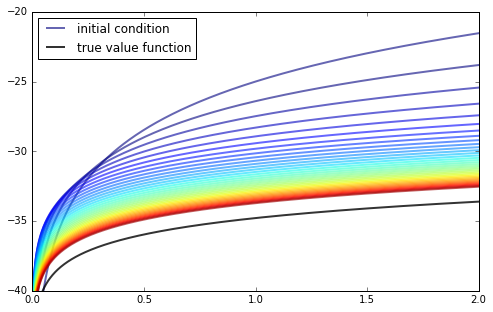

In [32]:
w = 5 * np.log(grid) - 25  # Initial condition
n = 35
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylim(-40, -20)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i in range(n):
    w = ddp.bellman_operator(w)
    ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
lb = 'true value function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='upper left')

plt.show()

We next plot the consumption policies along the value iteration.

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
1            6.924e+00      1.417e-02         
2            4.107e+00      2.741e-02         
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
1            6.924e+00      1.344e-02         
2            4.107e+00      2.639e-02         
3            3.866e+00      4.238e-02         
4            3.673e+00      5.609e-02         
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
1            6.924e+00      1.336e-02         
2            4.107e+00      2.634e-02         
3            3.866e+00      3.944e-02         
4            3.673e+00      5.251e-02         
5            3.489e+00      6.540e-02         
6            3.315e+00      7.811e-02         


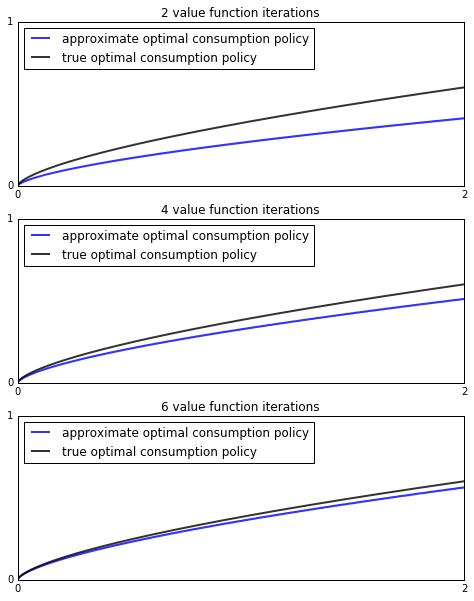

In [33]:
w = 5 * u(grid) - 25  # Initial condition

fig, ax = plt.subplots(3, 1, figsize=(8, 10))
true_c = c_star(grid)

for i, n in enumerate((2, 4, 6)):
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 2)
    ax[i].set_yticks((0, 1))
    ax[i].set_xticks((0, 2))

    w = 5 * u(grid) - 25  # Initial condition
    compute_fixed_point(ddp.bellman_operator, w, max_iter=n, print_skip=1)
    sigma = ddp.compute_greedy(w)  # Policy indices
    c_policy = f(grid) - grid[sigma]

    ax[i].plot(grid, c_policy, 'b-', lw=2, alpha=0.8,
               label='approximate optimal consumption policy')
    ax[i].plot(grid, true_c, 'k-', lw=2, alpha=0.8,
               label='true optimal consumption policy')
    ax[i].legend(loc='upper left')
    ax[i].set_title('{} value function iterations'.format(n))

### Dynamics of the capital stock

Finally, let us work on [Exercise 2](http://quant-econ.net/py/dp_intro.html#exercise-2),
where we plot the trajectories of the capital stock for three different discount factors,
$0.9$, $0.94$, and $0.98$, with initial condition $k_0 = 0.1$.

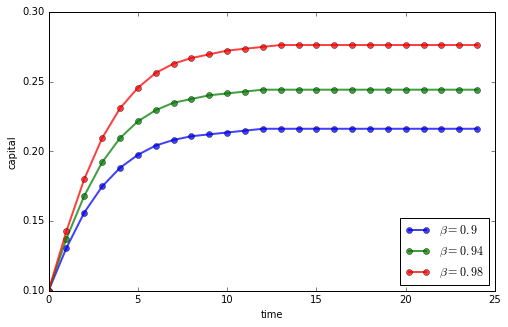

In [34]:
discount_factors = (0.9, 0.94, 0.98)
k_init = 0.1

# Search for the index corresponding to k_init
k_init_ind = np.searchsorted(grid, k_init)

sample_size = 25

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("time")
ax.set_ylabel("capital")
ax.set_ylim(0.10, 0.30)

# Create a new instance, not to modify the one used above
ddp0 = DiscreteDP(R, Q, beta, s_indices, a_indices)

for beta in discount_factors:
    ddp0.beta = beta
    res0 = ddp0.solve()
    k_path_ind = res0.mc.simulate(init=k_init_ind, ts_length=sample_size)
    k_path = grid[k_path_ind]
    ax.plot(k_path, 'o-', lw=2, alpha=0.75, label=r'$\beta = {}$'.format(beta))

ax.legend(loc='lower right')
plt.show()